In [15]:
# Import Libraries
from gurobi import *
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geopy.distance
from collections import defaultdict
from shapely.geometry import Point, LineString

# TEST Used for testing with a small sample
import random

In [16]:

# Load Polygons Data
polygons = gpd.read_file('../pandana/data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})



# Load Distance Matrix - GEOMETRY is Coming as STRING
distanceMatrix = pd.read_csv('../pandana/data/distance_matrix_schools_ourem.csv', dtype={'to':str})
distanceMatrix = distanceMatrix.drop(columns=['geometry'])

## Start Here

In [17]:
# Load Projection Data
population_projection = pd.read_csv('./data_gettin/df_alunos_subseccao.csv', dtype={'Unnamed: 0':str})
population_projection.rename(columns={'Unnamed: 0':'BGRI'}, inplace=True)
population_projection.index = population_projection['BGRI']
population_projection = population_projection.drop(columns=['BGRI'])
# Aggregate 2 and 3 cicles
population_projection['proj_sum_2_3'] = population_projection.loc[:,"2_CEB_Proj_2040"]+population_projection.loc[:,"3_CEB_Proj_2040"]

In [18]:
population_projection['proj_sum_2_3'].sum()

2583.8489999999997

In [19]:
# Load School (Ofer) Data
schools = gpd.read_file('./data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')
# schools = gpd.read_file('./data_gettin/escolas_ourem_antigo/gdf_escolas_Ourem2019_capacidades.shp')
# schools.Capacidade = schools.Capacidade.astype(float)
schools['Capacida_2_3'] = schools.Capacida_2+schools.Capacida_3
schools['Alunos_2CE_3CE'] = schools.Alunos_2CE+schools.Alunos_3CE

In [20]:
# CHANGE MADE TO VERIFY JOANAS PROBLEM!
schools.at[32,'Capacida_2_3'] = 728*1.25
schools[schools['FID_x']==47].Capacida_2_3

32    910
Name: Capacida_2_3, dtype: int64

In [21]:
# Council Selection - for plotting purpuses
def get_required_bgri(column, value):
    return polygons[polygons[column]==value]

selectedPolygon = get_required_bgri('DTMN11', '1421')

In [22]:
schools.columns

Index(['id', 'FID_x', 'Elegiveis_', 'Nome_Escol', 'Codigo_DGE', 'Salas_Pre_',
       'Salas_1CEB', 'Salas_2CEB', 'Salas_3CEB', 'Salas_Sec', 'FID_y',
       'Elegivei_1', 'Nome_Esc_1', 'Codigo_D_1', 'Alunos_EPE', 'Alunos_1CE',
       'Alunos_2CE', 'Alunos_3CE', 'Alunos_Sec', 'Capacidade', 'Capacida_1',
       'Capacida_2', 'Capacida_3', 'Capacida_4', 'geometry', 'Capacida_2_3',
       'Alunos_2CE_3CE'],
      dtype='object')

In [23]:
population_projection.columns

Index(['Pre_escolar_2011', '1_CEB_2011', '2_CEB_2011', '3_CEB_2011',
       'Secundario_2011', 'Code_Freg', 'Pre_escolar_percent', '1_CEB_percent',
       '2_CEB_percent', '3_CEB_percent', 'Secundario_percent',
       'Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040',
       '3_CEB_Proj_2040', 'Secundario_Proj_2040', 'proj_sum_2_3'],
      dtype='object')

In [24]:
population_projection[["Pre_escolar_Proj_2040", "1_CEB_Proj_2040", "2_CEB_Proj_2040","3_CEB_Proj_2040","Secundario_Proj_2040"]].columns

Index(['Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040',
       '3_CEB_Proj_2040', 'Secundario_Proj_2040'],
      dtype='object')

In [25]:
# Define some school globals to make capacity calculation easier 
schoolSelection = 'Capacida_2_3'
projectionSelection = 'proj_sum_2_3'
studentsActualEnrolledSelection = 'Alunos_EPE'
schoolsPre = schools[schools[schoolSelection]>0]

# Used in Demand and Capacity
selectecProjection = population_projection.loc[:,projectionSelection]
selectedSchoolCapacity = schoolsPre.loc[ : , schoolSelection ]


In [26]:
# For the 2 and 3 Cicles only ---- COMMENT THIS WHEN NOT USING 2 AND 3 CICLES
# selectecProjection = population_projection.loc[:,'2_CEB_Proj_2040']+population_projection.loc[:,'3_CEB_Proj_2040']
# selectedSchoolCapacity = schoolsPre.Capacida_2+schoolsPre.Capacida_3

In [27]:
# -------------- Decision Variables -------------- #

# School demand per BGRI
# demand = [15, 18, 14, 20]
# demand = dict(zip(population_projection.index,population_projection.Pre_escolar_Proj_2040))
demand = dict(zip(population_projection.index, selectecProjection))


# Plant capacity in thousands of units
# capacity = dict(zip(schoolsPre.index, schoolsPre.Capacidade))
# capacity = [20, 22, 17, 19, 5]
capacity = dict(zip(schoolsPre.index, selectedSchoolCapacity))

# Fixed costs for each plant
# fixedCosts = [12000, 15000, 17000, 13000, 16000]

# This would be operation Costs, if any were given. Right format would be a dict with school.index:school.cost
# fixedCosts = dict(zip(schools.index, schools.costs))
# fixedCosts = (schoolsPre.Capacidade/schoolsPre.Capacidade).values # This is the right one
# fixedCosts = (schoolsPre.Capacidade*1000).values


# Model
m = Model("capacitaded_location_schools")

# School open decision variables: open[p] == 1 if plant p is open.
open = m.addVars(list(capacity.keys()),
                 vtype=GRB.BINARY,
                 name="open")



Academic license - for non-commercial use only


In [28]:
# Transport To create Distance Matrix

transportCosts = []
notExistingBGRI = []

distanceMatrix_TD = list(zip(distanceMatrix.origin,distanceMatrix.to))
distanceMatrix_structure = dict(zip(distanceMatrix_TD,distanceMatrix.real_distance.values))

for bgri in demand:
    tempList = []
    for e in capacity:
        try:
            tempList.append(distanceMatrix_structure[(e,bgri)] * demand[bgri])
#             tempList.append(distanceMatrix_structure[(e,bgri)])
#             tempList.append(distanceMatrix[distanceMatrix['origin']==e][distanceMatrix['to']==bgri].real_distance.values[0])
        except:
            notExistingBGRI.append(bgri)
    transportCosts.append(tempList)
        

In [29]:
# Create Transport Decision Variables
transport = m.addVars(list(demand.keys()) ,list(capacity.keys()), obj=transportCosts,name="trans")

In [30]:
m.update()

In [31]:

# The objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# Production constraints
# Note that the right-hand limit sets the production to zero if the plant
# is closed
m.addConstrs(
    (transport.sum('*',p) <= capacity[p] for p in list(capacity.keys())),
    "Capacity")

# Using Python looping constructs, the preceding would be...
#
#for p in plants:
#  m.addConstr(sum(transport[w][p] for w in warehouses) <= capacity[p] * open[p],
#              "Capacity[%d]" % p)

# Demand constraints
m.addConstrs(
    (transport.sum(w) == demand[w] for w in list(demand.keys())),
    "Demand")

# ... and the preceding would be ...
#for w in warehouses:
#  m.addConstr(sum(transport[w][p] for p in plants) == demand[w], "Demand[%d]" % w)

# Save model
m.write('facility_Pre.lp')



# First, open all plants
# for p in capacity:
#     open[p].start = 1.0

# # Now close the plant with the highest fixed cost
# print('Initial guess:')
# maxFixed = max(fixedCosts)
# for p in plants:
#     if fixedCosts[p] == maxFixed:
#         open[p].start = 0.0
#         print('Closing plant %s' % p)
#         break
# print('')

# Use barrier to solve root relaxation
m.Params.method = 2

# Solve
m.optimize()


Changed value of parameter method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 1807 rows, 12607 columns and 25200 nonzeros
Variable types: 12600 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 9e+02]
Presolve removed 805 rows and 5642 columns
Presolve time: 0.03s
Presolved: 1002 rows, 6965 columns, 13930 nonzeros
Variable types: 6965 continuous, 0 integer (0 binary)
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.965e+03
 Factor NZ  : 8.339e+03 (roughly 3 MBytes of memory)
 Factor Ops : 7.564e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.50632892e+09  0.00000000e+00  4.09e+03 2.91e-11  1.49e+06     0s
   1   4.31826599e+08 -1.85599762e+08  2.64e+02 1.58e

In [32]:

# Print solution
print('\nTOTAL COSTS: %g' % m.objVal)
print('SOLUTION:')
listOfCapacities = []
listOfSchoolAndBgri = []
enrolledStudentsCount = []
for p in capacity:
    
    if open[p].x < 0.99:
        print('School %s open' % p)
        tempList = []
        for w in demand:
            if transport[w,p].x > 0:
                print('  Transport %g units from BGRI %s' % \
                      (transport[w,p].x, w))
                # Create a list of School and BGRI and the distance to school
                listOfSchoolAndBgri.append([w,p,distanceMatrix_structure[p,w]])
                tempList.append(transport[w,p].x)
        
        print('SUM of School %d : %f' % (p, sum(tempList)))
        
        # To create a DF with school and number of students
        enrolledStudentsCount.append([p,sum(tempList)])
        # To verify if the correct number of students are enrolled
        listOfCapacities.append(sum(tempList))
            
    else:
        print('School is %s closed!' % p)
pd_SchoolAndBgri = pd.DataFrame(listOfSchoolAndBgri, columns=['BGRI','school','real_distance'])
pd_SchoolAndStudents = pd.DataFrame(enrolledStudentsCount, columns=['school', 'students'])


TOTAL COSTS: 4.59948e+07
SOLUTION:
School 6 open
  Transport 1.303 units from BGRI 14210300111
  Transport 0.6515 units from BGRI 14210300112
  Transport 1.303 units from BGRI 14210300115
  Transport 1.303 units from BGRI 14210300117
  Transport 1.303 units from BGRI 14210300119
  Transport 0.6515 units from BGRI 14210300202
  Transport 0.6515 units from BGRI 14210300208
  Transport 0.6515 units from BGRI 14210300211
  Transport 1.303 units from BGRI 14210300212
  Transport 0.6515 units from BGRI 14210300218
  Transport 1.303 units from BGRI 14210300221
  Transport 1.303 units from BGRI 14210300304
  Transport 1.303 units from BGRI 14210300305
  Transport 0.6515 units from BGRI 14210300306
  Transport 1.303 units from BGRI 14210300307
  Transport 0.6515 units from BGRI 14210300309
  Transport 0.6515 units from BGRI 14210300310
  Transport 0.6515 units from BGRI 14210300312
  Transport 0.6515 units from BGRI 14210300313
  Transport 0.6515 units from BGRI 14210300314
  Transport 0.72007

  Transport 0.568582 units from BGRI 14211200210
  Transport 1.13716 units from BGRI 14211200215
  Transport 0.568582 units from BGRI 14211200217
  Transport 1.13716 units from BGRI 14211200218
  Transport 1.13716 units from BGRI 14211200220
  Transport 1.13716 units from BGRI 14211200221
  Transport 0.568582 units from BGRI 14211200223
  Transport 0.568582 units from BGRI 14211200225
  Transport 1.13716 units from BGRI 14211200227
  Transport 1.70575 units from BGRI 14211200308
  Transport 2.27433 units from BGRI 14211200309
  Transport 1.70575 units from BGRI 14211200312
  Transport 0.568582 units from BGRI 14211200313
  Transport 0.568582 units from BGRI 14211200326
  Transport 0.568582 units from BGRI 14211200416
  Transport 4.67547 units from BGRI 14211300102
  Transport 0.935094 units from BGRI 14211300103
  Transport 0.935094 units from BGRI 14211300104
  Transport 1.87019 units from BGRI 14211300108
  Transport 0.935094 units from BGRI 14211300114
  Transport 2.80528 units from

  Transport 0.935094 units from BGRI 14211300419
  Transport 0.935094 units from BGRI 14211300421
  Transport 2.80528 units from BGRI 14211300422
  Transport 0.935094 units from BGRI 14211300423
  Transport 0.935094 units from BGRI 14211300424
  Transport 1.87019 units from BGRI 14211300501
  Transport 1.87019 units from BGRI 14211300503
  Transport 1.87019 units from BGRI 14211300504
  Transport 2.80528 units from BGRI 14211300507
  Transport 1.87019 units from BGRI 14211300508
  Transport 0.935094 units from BGRI 14211300509
  Transport 0.935094 units from BGRI 14211300511
  Transport 3.74038 units from BGRI 14211300512
  Transport 5.62724 units from BGRI 14211500113
  Transport 2.2509 units from BGRI 14211500114
  Transport 2.2509 units from BGRI 14211500115
  Transport 3.37635 units from BGRI 14211500117
  Transport 2.2509 units from BGRI 14211500119
  Transport 5.62724 units from BGRI 14211500502
  Transport 1.12545 units from BGRI 14211500506
  Transport 3.37635 units from BGRI 1

  Transport 2.26257 units from BGRI 14210800411
  Transport 3.9595 units from BGRI 14210800415
  Transport 2.26257 units from BGRI 14210800417
  Transport 0.565643 units from BGRI 14210800419
  Transport 0.565643 units from BGRI 14210800421
  Transport 1.13129 units from BGRI 14210800501
  Transport 0.565643 units from BGRI 14210800502
  Transport 0.565643 units from BGRI 14210800505
  Transport 1.13129 units from BGRI 14210800506
  Transport 0.565643 units from BGRI 14210800508
  Transport 1.13129 units from BGRI 14210800510
  Transport 0.565643 units from BGRI 14210800512
  Transport 0.565643 units from BGRI 14210800513
  Transport 0.565643 units from BGRI 14210800514
  Transport 1.13129 units from BGRI 14210800515
  Transport 0.565643 units from BGRI 14210800601
  Transport 1.69693 units from BGRI 14210800605
  Transport 0.565643 units from BGRI 14210800606
  Transport 0.565643 units from BGRI 14210800608
  Transport 0.565643 units from BGRI 14210800609
  Transport 0.565643 units fr

  Transport 1.06425 units from BGRI 14211100316
  Transport 4.25701 units from BGRI 14211100317
  Transport 1.06425 units from BGRI 14211100320
  Transport 1.06425 units from BGRI 14211100322
  Transport 2.1285 units from BGRI 14211100323
  Transport 1.06425 units from BGRI 14211100401
  Transport 2.1285 units from BGRI 14211100402
  Transport 1.06425 units from BGRI 14211100618
  Transport 1.06425 units from BGRI 14211100619
  Transport 1.06425 units from BGRI 14211100621
  Transport 1.06425 units from BGRI 14211100622
  Transport 5.32126 units from BGRI 14211100624
  Transport 7.44976 units from BGRI 14211100625
  Transport 1.06425 units from BGRI 14211100701
  Transport 5.32126 units from BGRI 14211100703
  Transport 3.19275 units from BGRI 14211100704
  Transport 2.1285 units from BGRI 14211100706
  Transport 1.06425 units from BGRI 14211100710
  Transport 3.19275 units from BGRI 14211100711
  Transport 1.06425 units from BGRI 14211100712
  Transport 1.06425 units from BGRI 1421110

In [33]:
# Create the metrics from the pd with alocated demands and real_distance
schoolsPre['dist_media'] = pd_SchoolAndBgri[['school','real_distance']].groupby('school').mean()
schoolsPre['dist_min'] = pd_SchoolAndBgri[['school','real_distance']].groupby('school').min()
schoolsPre['dist_max'] = pd_SchoolAndBgri[['school','real_distance']].groupby('school').max()
schoolsPre['dist_STDeviation'] = pd_SchoolAndBgri[['school','real_distance']].groupby('school').std()


# Add to the selected schools how many students are alocated
schoolsPre = pd.merge(schoolsPre, pd_SchoolAndStudents[['students']], how='left', left_on=[schoolsPre.index], right_on=[pd_SchoolAndStudents.school])



/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [34]:
schoolsPre

,key_0,id,FID_x,Elegiveis_,Nome_Escol,Codigo_DGE,Salas_Pre_,Salas_1CEB,Salas_2CEB,Salas_3CEB,...,Capacida_3,Capacida_4,geometry,Capacida_2_3,Alunos_2CE_3CE,dist_media,dist_min,dist_max,dist_STDeviation,students
0,6,0,6,1,"30 - EB Cónego Dr. Manuel Lopes Perdigão (EB2,3)",1421966,0,0,7,10,...,280,0,POINT (-35227.397 5850.488),476,214,6994.022571,0.000,16277.802,4478.990725,323.304980
1,10,0,12,1,"22 - EB 4.º Conde de Ourém (EB2,3)",1421670,0,0,12,15,...,420,0,POINT (-37491.584 -1334.435),756,427,4061.582954,88.893,8817.790,2026.665338,373.878226
2,16,0,22,1,36 - Colégio Sagrado Coração de Maria,1421201,0,0,5,7,...,196,0,POINT (-46853.314 -3787.454),336,366,4498.189882,82.215,9118.811,2838.429706,336.000000
3,20,0,27,1,37 - Centro de Estudos de Fátima,1421978,0,0,4,6,...,168,420,POINT (-45522.192 -3213.331),280,255,4185.567370,0.000,8844.860,2315.247774,280.000000
4,21,0,28,1,38 - Colégio de São Miguel de Fátima,1421117,0,0,5,7,...,196,504,POINT (-46818.063 -2929.745),336,384,4376.149873,519.932,11355.940,2897.008819,311.180840
5,29,0,41,1,"9 - EB de Freixianda (EB2,3)",1421722,0,0,5,9,...,252,0,POINT (-28249.712 10615.427),392,124,4352.383703,166.749,9334.355,2435.356786,137.798173
6,32,0,47,1,"16 - EBS de Ourém (EB2,3/ES)",1421400,0,0,9,17,...,476,952,POINT (-38187.510 -881.624),910,501,5400.700811,162.409,12092.410,3067.695697,821.686781


In [35]:
pd_SchoolAndBgri[['school','real_distance']].groupby('school').mean()

,real_distance
school,
6,6994.022571
10,4061.582954
16,4498.189882
20,4185.567370
21,4376.149873
29,4352.383703
32,5400.700811


In [36]:
# clean after merge
schoolsPre = schoolsPre.rename(columns={'key_0':'school'})
schoolsPre.index = schoolsPre.school

In [37]:
schoolsPre

,school,id,FID_x,Elegiveis_,Nome_Escol,Codigo_DGE,Salas_Pre_,Salas_1CEB,Salas_2CEB,Salas_3CEB,...,Capacida_3,Capacida_4,geometry,Capacida_2_3,Alunos_2CE_3CE,dist_media,dist_min,dist_max,dist_STDeviation,students
school,,,,,,,,,,,,,,,,,,,,,
6,6,0,6,1,"30 - EB Cónego Dr. Manuel Lopes Perdigão (EB2,3)",1421966,0,0,7,10,...,280,0,POINT (-35227.397 5850.488),476,214,6994.022571,0.000,16277.802,4478.990725,323.304980
10,10,0,12,1,"22 - EB 4.º Conde de Ourém (EB2,3)",1421670,0,0,12,15,...,420,0,POINT (-37491.584 -1334.435),756,427,4061.582954,88.893,8817.790,2026.665338,373.878226
16,16,0,22,1,36 - Colégio Sagrado Coração de Maria,1421201,0,0,5,7,...,196,0,POINT (-46853.314 -3787.454),336,366,4498.189882,82.215,9118.811,2838.429706,336.000000
20,20,0,27,1,37 - Centro de Estudos de Fátima,1421978,0,0,4,6,...,168,420,POINT (-45522.192 -3213.331),280,255,4185.567370,0.000,8844.860,2315.247774,280.000000
21,21,0,28,1,38 - Colégio de São Miguel de Fátima,1421117,0,0,5,7,...,196,504,POINT (-46818.063 -2929.745),336,384,4376.149873,519.932,11355.940,2897.008819,311.180840
29,29,0,41,1,"9 - EB de Freixianda (EB2,3)",1421722,0,0,5,9,...,252,0,POINT (-28249.712 10615.427),392,124,4352.383703,166.749,9334.355,2435.356786,137.798173
32,32,0,47,1,"16 - EBS de Ourém (EB2,3/ES)",1421400,0,0,9,17,...,476,952,POINT (-38187.510 -881.624),910,501,5400.700811,162.409,12092.410,3067.695697,821.686781


In [38]:
sum(listOfCapacities)

2583.849

In [39]:
population_projection.Pre_escolar_Proj_2040.sum()

1009.0872000000003

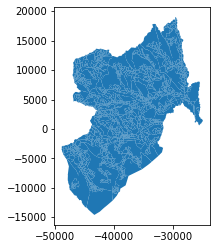

In [40]:
selectedPolygon.plot()

### PLOT the results

In [41]:
prePolygonLines = pd.merge(selectedPolygon, pd_SchoolAndBgri, how='left', left_on=[selectedPolygon.BGRI11], right_on=[pd_SchoolAndBgri.BGRI])
# Some BGRI are missing, or the demand is zero
prePolygonLines = prePolygonLines[prePolygonLines['school'].notna()]
prePolygonLines.school = prePolygonLines.school.astype(int)
prePolygonLines.geometry = prePolygonLines.centroid

In [42]:
# Get List of lines
listOfLines = []

for e in prePolygonLines.iterrows():
    pointSchool = [schoolsPre[schoolsPre.index==e[1].school].geometry.x.values[0], schoolsPre[schoolsPre.index==e[1].school].geometry.y.values[0]]
    line = LineString([[e[1].geometry.x, e[1].geometry.y],pointSchool])
    listOfLines.append(line)
prePolygonLines['line'] = listOfLines

In [43]:
teste = prePolygonLines
teste.geometry = teste.line

In [44]:
schoolsPre.students = schoolsPre.students.fillna(0)

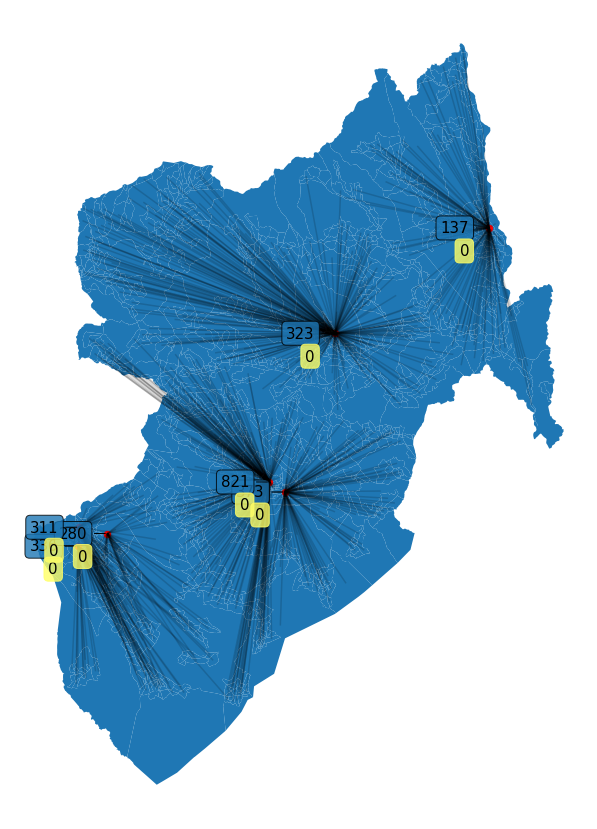

In [45]:
fig, ax = plt.subplots(figsize=(15,15))
teste.plot(ax=ax, alpha=0.15, color='black')

selectedPolygon.plot(ax=ax)
ax.set_axis_off()

for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    ax.annotate(int(row['students']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Capacidade']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66')
             );
    


schoolsPre.plot(ax=ax, markersize=40, color='red', marker='o', label='centroid')

### Plot Routine For Ourem

In [46]:
# # Códido maluco do Jan

# # Load Data
gdf_freguesias_CAOP2018 = gpd.read_file('../pandana/data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
gdf_freguesias_CAOP2018 = gdf_freguesias_CAOP2018[gdf_freguesias_CAOP2018['code_mun']=='1421']
gpd_COS_municipio = gpd.read_file('../pandana/data/ourem_map_data/gpd_COS_Ourem.shp')
gdf_open_street2019_municipio = gpd.read_file('../pandana/data/ourem_map_data/gdf_open_street2019_Ourem.shp')


# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



### Plot the Capacitaded Model Result

/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


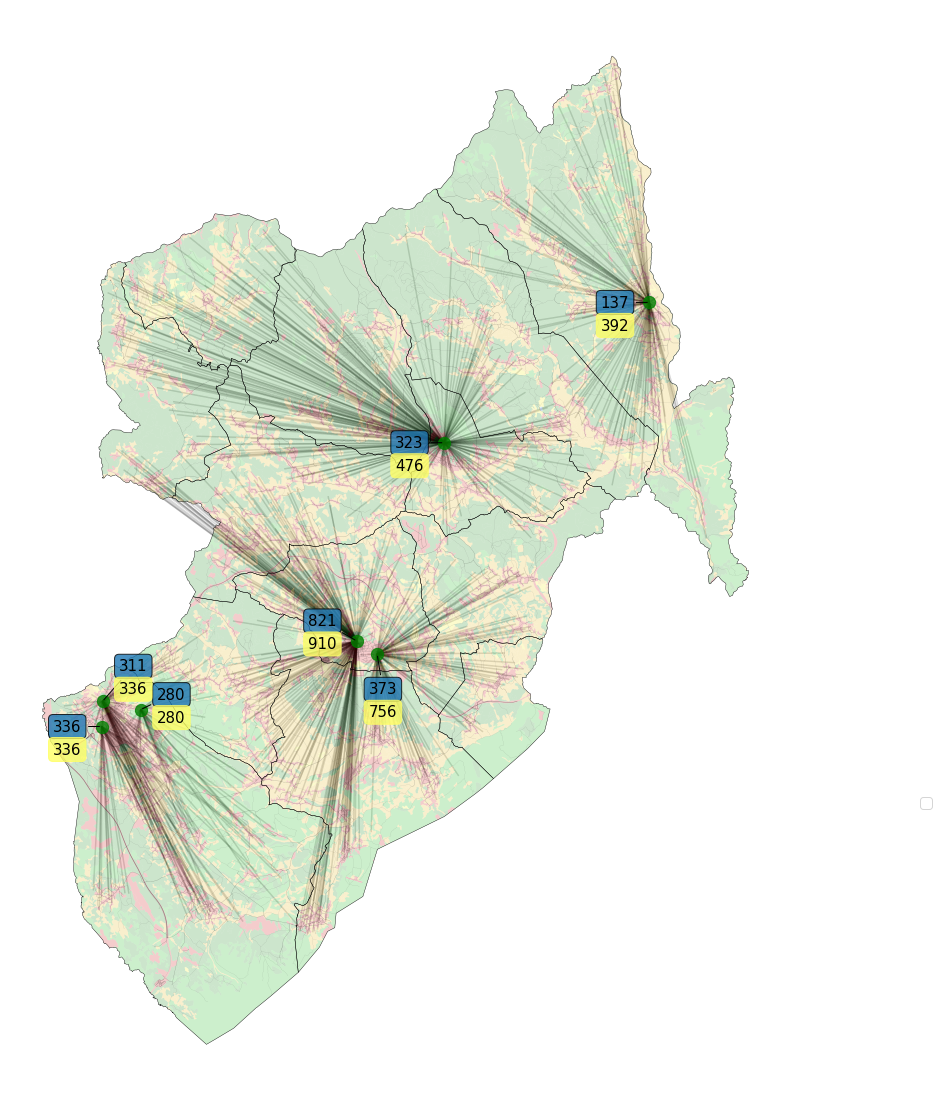

In [47]:
# _-------------_ Criação do Gráfico _-----------_
fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)


#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)
    
teste.plot(ax=ax, alpha=0.15, color='black')


ax.set_axis_off()

markersize = 150
# If the School has critic mass
schoolsPre.plot(ax=ax, markersize=markersize, color='green', marker='o', alpha=0.8,zorder=50)
# IF the school is a closing Candidate
schoolsPre[schoolsPre['students']<=22].plot(ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Equipamento com menos de 21 alunos', alpha=0.8, zorder=60)
plt.legend(prop={'size':15}, bbox_to_anchor = (1.2,0.28))


for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    
    # Offset Correction
    offset = {'x':45, 'y':-15} if idx==38 else offset
    offset = {'x':45, 'y':-15} if idx==36 else offset
    offset = {'x':45, 'y':-15} if idx==27 else offset
    offset = {'x':45, 'y':35} if idx==13 else offset
    offset = {'x':0, 'y':-30} if idx==22 else offset
    offset = {'x':45, 'y':15} if idx==20 else offset # 2_3
    offset = {'x':45, 'y':35} if idx==21 else offset # 2_3
    offset = {'x':20, 'y':-35} if idx==10 else offset # 2_3
    offset = {'x':-20, 'y':20} if idx==32 else offset # 2_3
    ax.annotate(int(row['students']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row[schoolSelection]), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66')
             );
    

# 1000 is the magic number
# schoolsPre.plot(ax=ax, markersize=150, color='green', marker='o', label='centroid', alpha=0.8, zorder=1000)

### Plot the current over Projected number of students

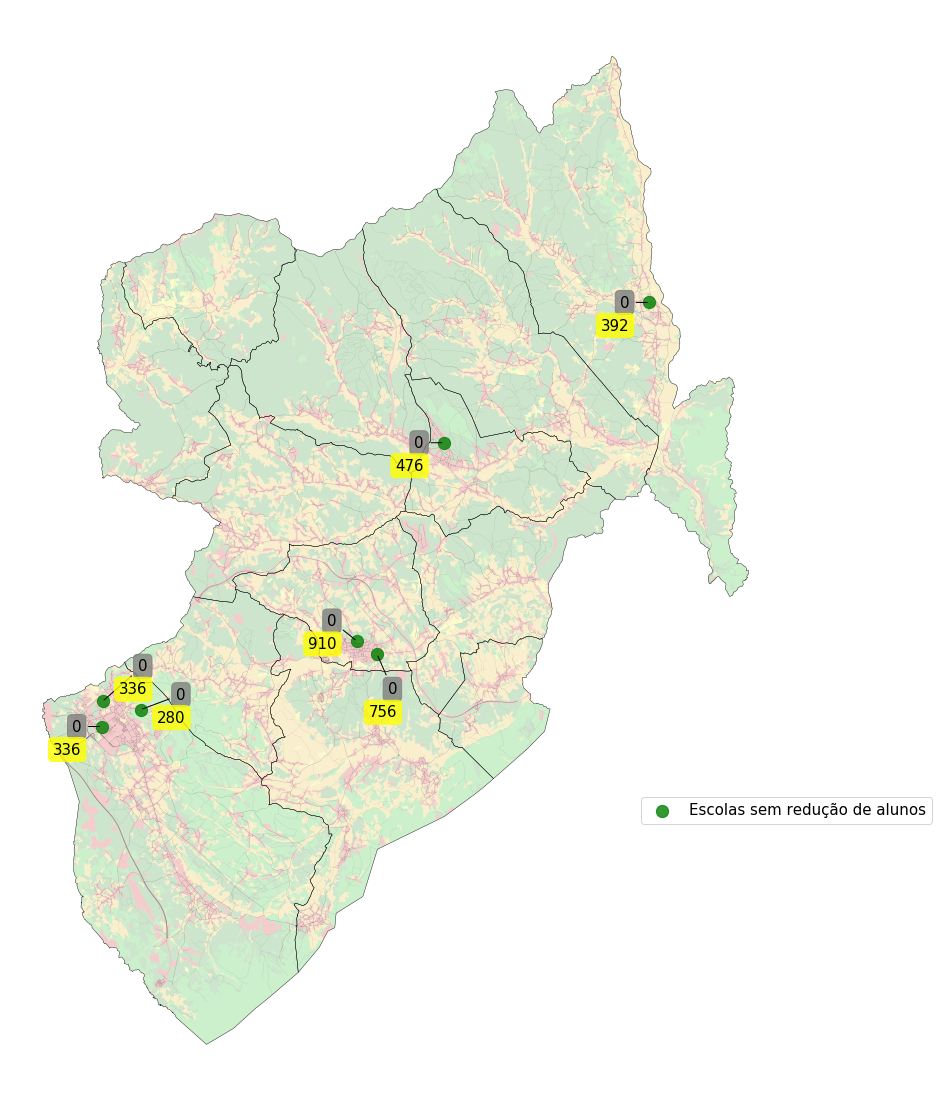

In [48]:
# _-------------_ Criação do Gráfico _-----------_
fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)


#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)
    
# teste.plot(ax=ax, alpha=0.15, color='black')


ax.set_axis_off()

markersize = 150
# If the School has critic mass
schoolsPre.plot(ax=ax, markersize=markersize, color='green', marker='o', alpha=0.8,zorder=50, label='Escolas sem redução de alunos')

# schoolsPre[schoolsPre.students<schoolsPre.loc[:,studentsActualEnrolledSelection]].plot(ax=ax, markersize=markersize, color='#B22222', marker='s', label='Escola com redução de alunos', alpha=0.8, zorder=60)

# IF the school is a closing Candidate
plt.legend(prop={'size':15}, bbox_to_anchor = (1.2,0.28))


for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    
    # Offset Correction
    offset = {'x':45, 'y':-15} if idx==38 else offset
    offset = {'x':45, 'y':-15} if idx==36 else offset
    offset = {'x':45, 'y':-15} if idx==27 else offset
    offset = {'x':45, 'y':35} if idx==13 else offset
    offset = {'x':0, 'y':-30} if idx==22 else offset
    offset = {'x':45, 'y':15} if idx==20 else offset # 2_3
    offset = {'x':45, 'y':35} if idx==21 else offset # 2_3
    offset = {'x':20, 'y':-35} if idx==10 else offset # 2_3
    offset = {'x':-20, 'y':20} if idx==32 else offset # 2_3
    ax.annotate(int(row[studentsActualEnrolledSelection]), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='gray'),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row[schoolSelection]), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='yellow')
             );
    

# 1000 is the magic number
# schoolsPre.plot(ax=ax, markersize=150, color='green', marker='o', label='centroid', alpha=0.8, zorder=1000)

In [49]:
schoolsPre.to_excel(schoolSelection + '.xls')

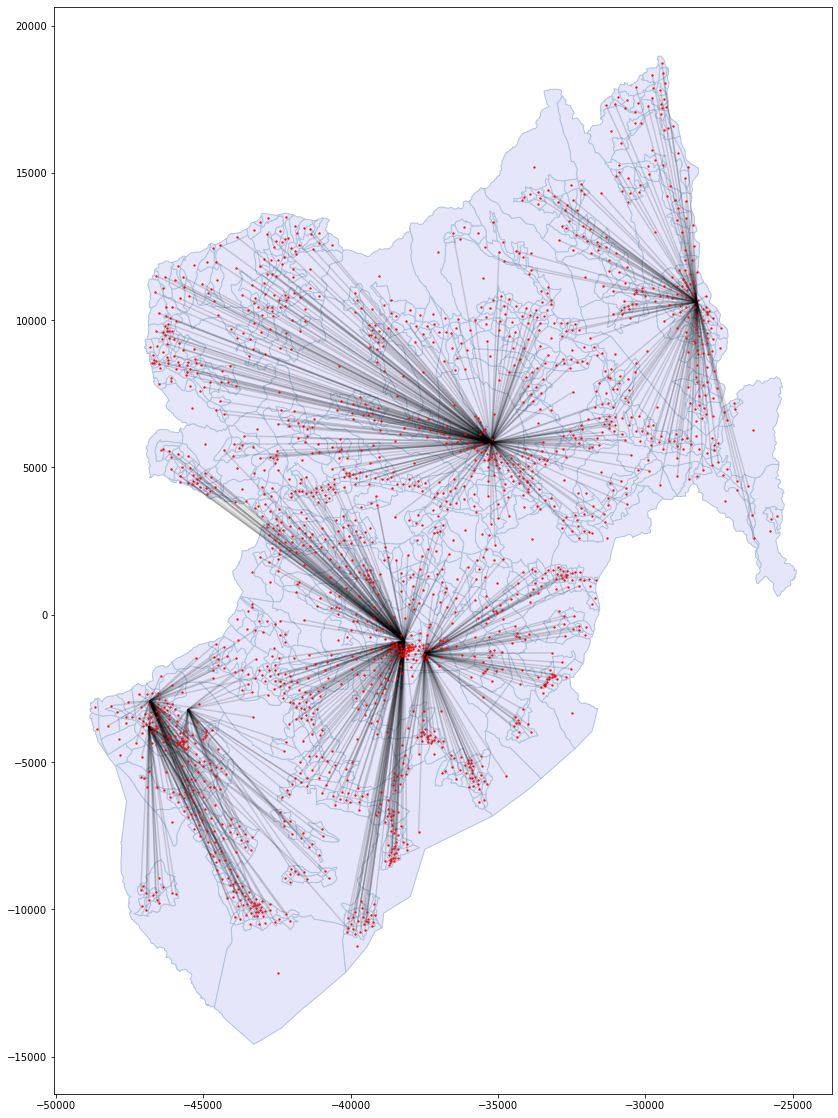

In [50]:

fig, ax = plt.subplots(figsize=(20, 20))
teste.plot(ax=ax, alpha=0.15, color='black')
selectedPolygon.centroid.plot(ax=ax, alpha=0.8, markersize=2, color='red',zorder=100)
selectedPolygon.plot(ax=ax,facecolor='#E6E6FA', edgecolor='#B0C4DE', )

# schoolsPre.plot(ax=ax, alpha=0.8, zorder=2000,color='blue', markersize=80)
